# Laboratorio de predicción lineal

## Intentaremos aplicar predicción lineal sobre señales de voz.

In [1]:
%pip install wget

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib notebook

In [35]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import wget
import scipy.io.wavfile as wave
import IPython
from scipy.linalg import toeplitz, inv
from scipy.fftpack import fft

## Sabiendo que las señales de voz pueden ser modeladas con un modelo autorregresivo:

### 1. Realizar una grabación de duración T = 2 s y fs = 8 kHz de los sonidos /a/ y /sh/.

In [4]:
a_url = 'https://raw.githubusercontent.com/ManuMollon261297/PASA/master/TP3/recordings/a.wav'
a_file = wget.download(a_url)

sh_url = 'https://raw.githubusercontent.com/ManuMollon261297/PASA/master/TP3/recordings/sh.wav'
sh_file = wget.download(sh_url)

In [5]:
fs, a_arr = wave.read(a_file)
# Downsample fs to 8KHz
desired_fs = 8000
final_len = int(len(a_arr) * (8000/fs))
resampled_a = sig.resample(a_arr, final_len)
norm_a = resampled_a/np.amax(resampled_a)

print("fs = "+str(desired_fs))
print("Number of samples = "+ str(len(resampled_a)))
IPython.display.Audio(resampled_a,rate=desired_fs)

fs = 8000
Number of samples = 20640


In [6]:
fs, sh_arr = wave.read(str(sh_file))

# Downsample fs to 8KHz
desired_fs = 8000
final_len = int(len(sh_arr) * (8000/fs))
resampled_sh = sig.resample(sh_arr, final_len)
norm_sh = resampled_sh/np.amax(resampled_sh)

print("fs = "+str(desired_fs))
print("Number of samples = "+ str(len(resampled_sh)))
IPython.display.Audio(resampled_sh,rate=desired_fs)

fs = 8000
Number of samples = 19616


### 2. Para ambos sonidos, realizar la predicción forward con $ N_{o} = 1 $, y representar el error cuadrático medio J en función de M, para valores de M entre 1 y 100.

In [7]:
def autocorreltion(x):
  norm_x = (x - x.mean())/(abs(x).max())
  return np.correlate(norm_x,norm_x,mode='full') / len(x)

def LevinsonDurbin(r,debug = False):
  last_delta = np.conj(r[1])
  a_coefs = 1
  M = len(r)-1
  P_values = []
  P_values.append(r[0])
  for i in range(1,M):
    k = (-last_delta) / P_values[-1]
    last_coefs = a_coefs
    a_coefs = np.ones(i+1, dtype= np.float64)
    a_coefs[-1] = k 
    if (i>1):
      a_coefs[1:-1] = last_coefs[1:] + k*np.flip(np.conj(last_coefs[1:]))
    P_values.append( P_values[-1] * (1- (abs(k)**2) ) )
    last_delta = np.dot(np.flip(r[1:i+2]),a_coefs)
    if debug:
      print("m = "+str(i))
      print("a_coefs:",a_coefs)
      print("p = "+str(P_values[-1]))
      print("k = "+str(k))
      print("delta = ")
      print(last_delta)
  return a_coefs,P_values

In [8]:
def a_sub_k_to_w_sub_k(a_arr):
    return (-np.asarray(a_arr[1:]))

In [13]:
def plot_m_vs_j(ms, js):
    plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
    plt.ylabel('Pm')
    plt.xlabel('M')
    plt.title('J(M)')
    plt.grid('on')
    plt.xticks(np.arange(1, len(ms), step=4))
    plt.plot(ms, js)
    plt.show()

In [10]:
# Levinson Durbin Test
M = 5
r = autocorreltion(resampled_a)
r = r[r.argmax():r.argmax()+M]
print("r:",r)
LevinsonDurbin(r,debug = True)

r: [0.02368022 0.02105136 0.01541871 0.0103042  0.00784205]
m = 1
a_coefs: [ 1.         -0.88898508]
p = 0.004965873222952802
k = -0.8889850810340103
delta = 
-0.003295633708181237
m = 2
a_coefs: [ 1.         -1.47896575  0.66365643]
p = 0.0027787047128308034
k = 0.6636564326589052
delta = 
0.001471326918779622
m = 3
a_coefs: [ 1.         -1.83037249  1.44677027 -0.529501  ]
p = 0.0019996356408529662
k = -0.5295009980678044
delta = 
0.00014213280628778968


(array([ 1.        , -1.83037249,  1.44677027, -0.529501  ]),
 [0.023680221140579927,
  0.004965873222952802,
  0.0027787047128308034,
  0.0019996356408529662])

### Forward prediction of 'a' signal with $ N_{o} = 1 $:

<IPython.core.display.Javascript object>


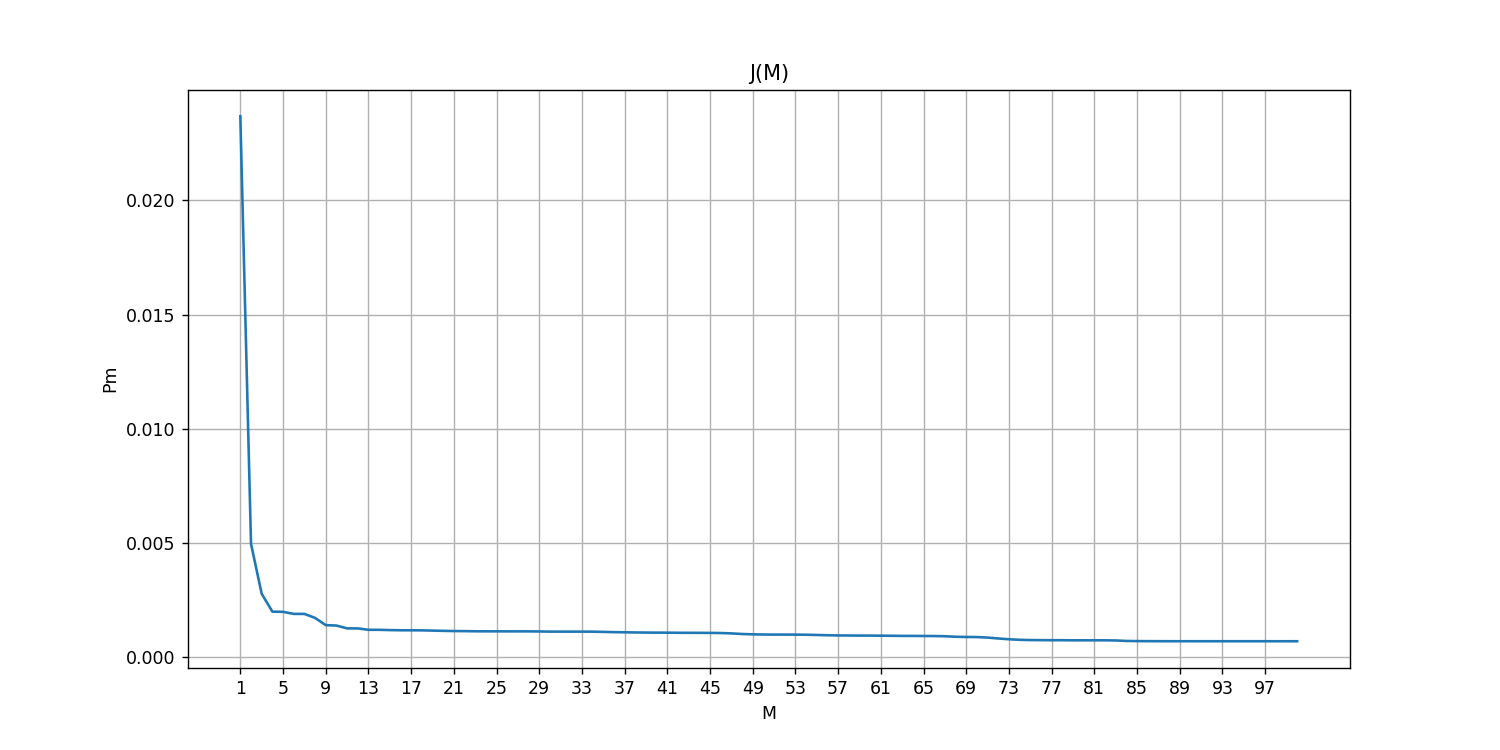

In [14]:
# Representar el error cuadrático medio J en función de M, para valores de M entre 1 y 100.
i = 101
r = autocorreltion(resampled_a)
r = r[r.argmax():r.argmax()+i]
M = len(r)-1
m = np.arange(1,M+1)
_, p_list = LevinsonDurbin(r)
plot_m_vs_j(m, p_list)

### Forward prediction of 'sh' signal with $ N_{o} = 1 $:

<IPython.core.display.Javascript object>


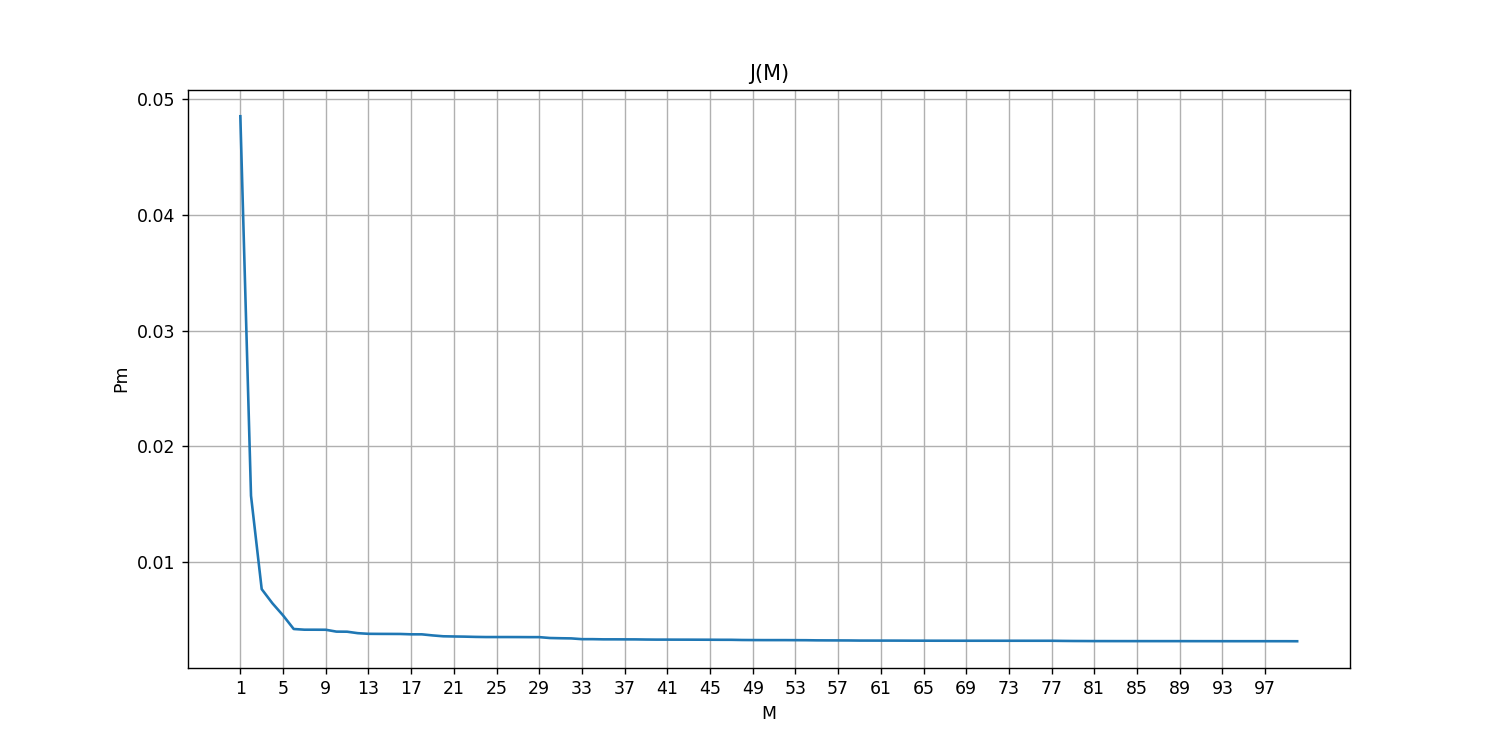

In [15]:
# Representar el error cuadrático medio J en función de M, para valores de M entre 1 y 100.
i = 101
r = autocorreltion(resampled_sh)
r = r[r.argmax():r.argmax()+i]
M = len(r)-1
m = np.arange(1,M+1)
_, p_list = LevinsonDurbin(r)
plot_m_vs_j(m, p_list)

### 3. Para ambos sonidos, analizar cualitativa y cuantitativamente la señal del error de predicción y el espectro $ H(e^{jω}) $ del filtro autorregresivo estimado para M = 1, 6, 12, 24, 100. Comparar este espectro con el espectro obtenido por estimación no-paramétrica.

In [17]:
def filterW(data, w_o):
    samples = len(data)
    if type(w_o) != int:
        M = len(w_o)
    else:
        M = 1
    filtered = np.zeros(samples)
    filtered = sig.filtfilt(w_o, [1], data)
    return filtered

In [42]:
def plot_fm_fft(fs, data, m):
    N = len(data)
    fft_res = fft(x=data, n=N)
    Spd = np.power(np.abs(fft_res), 2)
    Spd /= sum(Spd)
    freqs = np.linspace(0, fs/2, N//2)
    plt.semilogx(freqs, 2/N * np.abs(Spd[:N//2]), label='M = '+str(M))

<IPython.core.display.Javascript object>


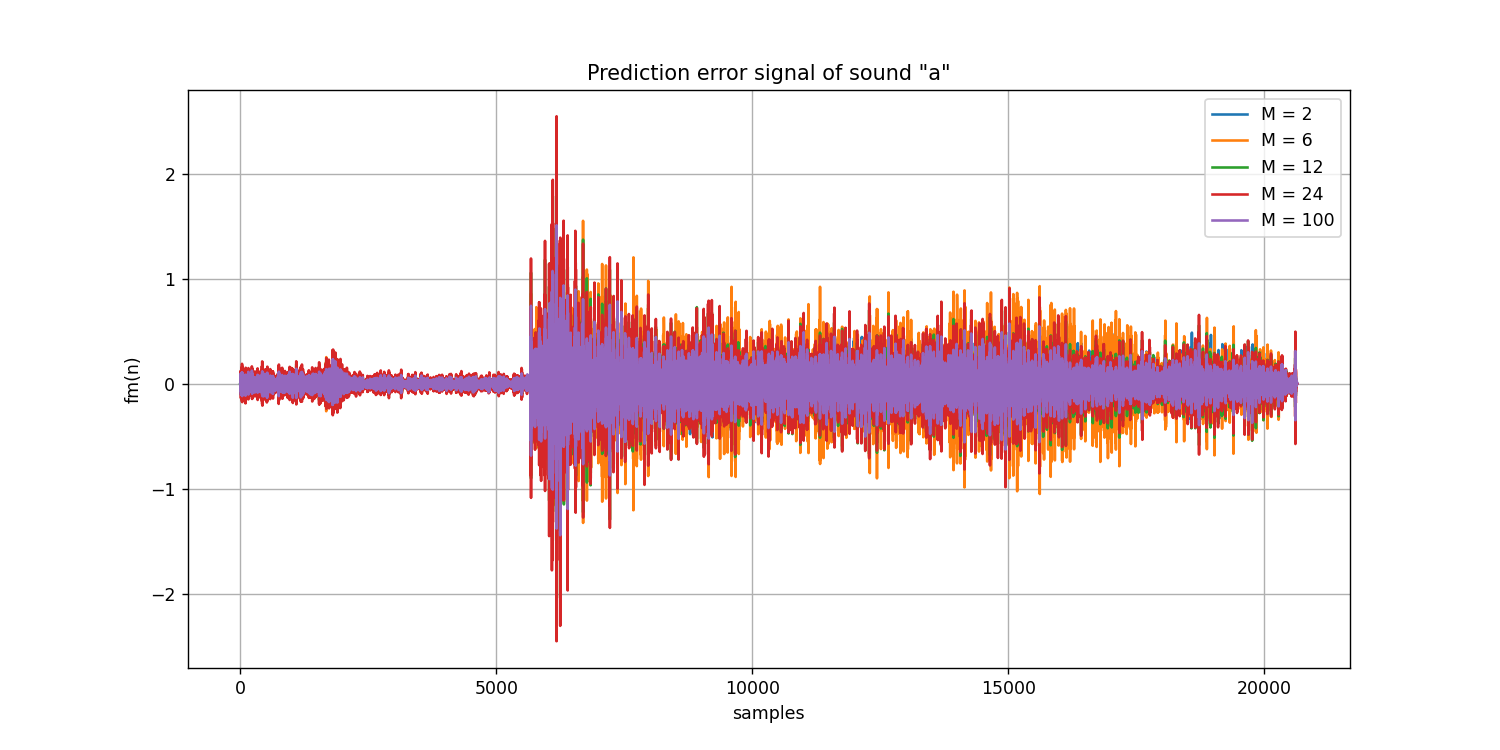

In [43]:
plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('fm(n)')
plt.xlabel('samples')
plt.title('Prediction error signal of sound "a"')
plt.grid('on')

for M in (2, 6, 12, 24, 100):
    i = M+1
    r = autocorreltion(norm_a)
    r = r[r.argmax():r.argmax()+i]
    a_coefs, p_list = LevinsonDurbin(r)
    fm = filterW(norm_a, a_coefs)
    plt.plot(fm, label='M = '+str(M))
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


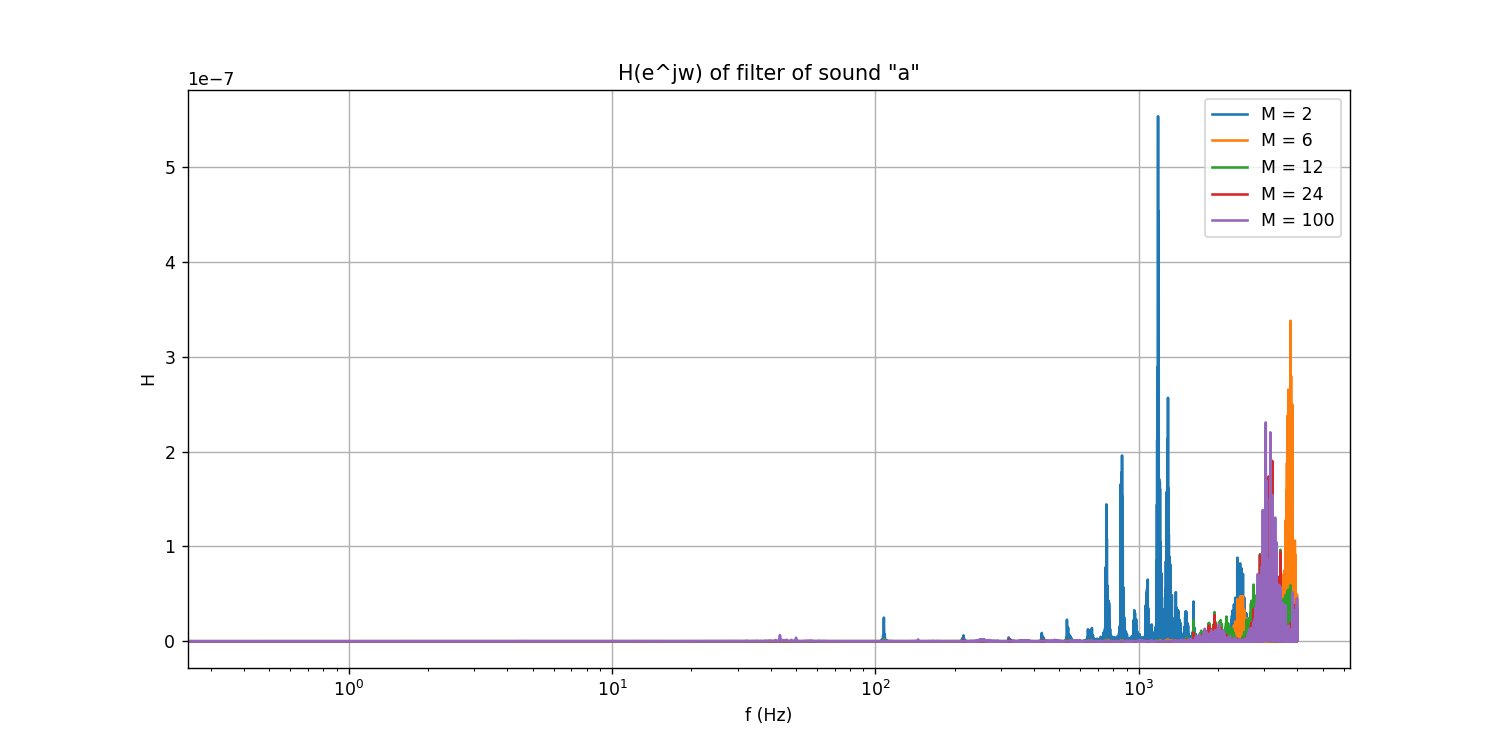

In [44]:
plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('H')
plt.xlabel('f (Hz)')
plt.title('H(e^jw) of filter of sound "a"')
plt.grid('on')

fs = 8000

for M in (2, 6, 12, 24, 100):
    i = M+1
    r = autocorreltion(norm_a)
    r = r[r.argmax():r.argmax()+i]
    a_coefs, p_list = LevinsonDurbin(r)
    fm = filterW(norm_a, a_coefs)
    plot_fm_fft(fs, fm, M)
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


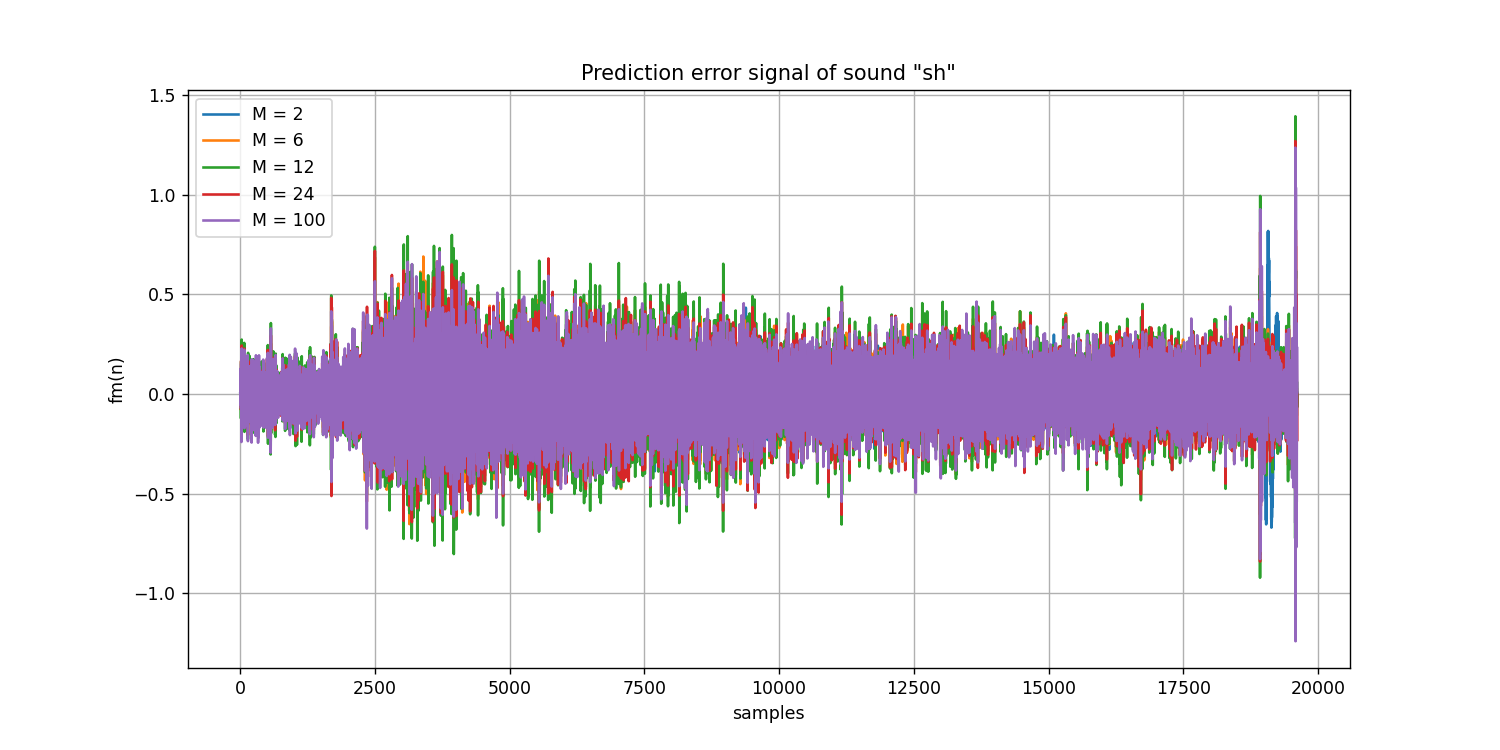

In [45]:
plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('fm(n)')
plt.xlabel('samples')
plt.title('Prediction error signal of sound "sh"')
plt.grid('on')

for M in (2, 6, 12, 24, 100):
    i = M+1
    r = autocorreltion(norm_sh)
    r = r[r.argmax():r.argmax()+i]
    a_coefs, p_list = LevinsonDurbin(r)
    fm = filterW(norm_sh, a_coefs)
    plt.plot(fm, label='M = '+str(M))
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


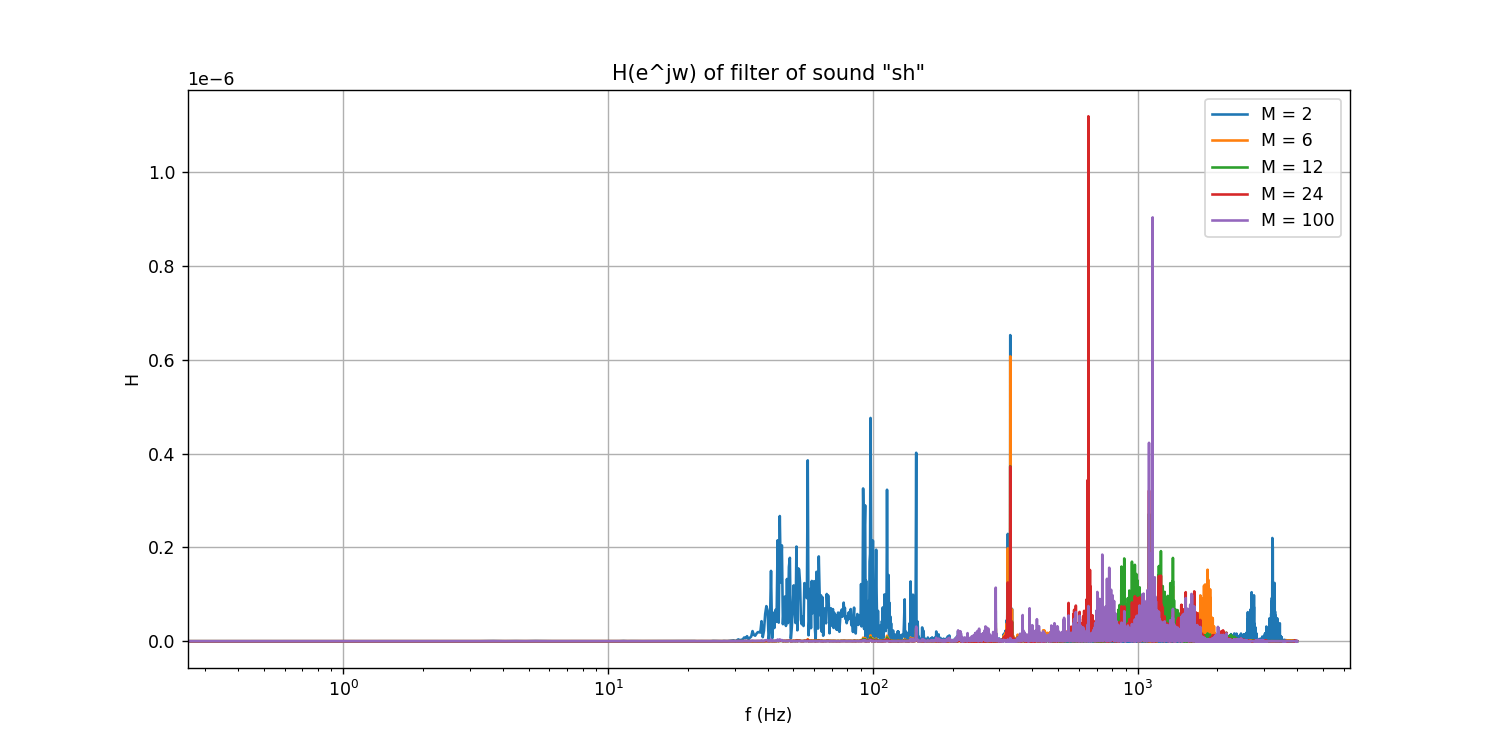

In [46]:
plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('H')
plt.xlabel('f (Hz)')
plt.title('H(e^jw) of filter of sound "sh"')
plt.grid('on')

fs = 8000

for M in (2, 6, 12, 24, 100):
    i = M+1
    r = autocorreltion(norm_sh)
    r = r[r.argmax():r.argmax()+i]
    a_coefs, p_list = LevinsonDurbin(r)
    fm = filterW(norm_sh, a_coefs)
    plot_fm_fft(fs, fm, M)
plt.legend()
plt.show()

### 4. ¿Cuál es el orden óptimo Mo para cada sonido?

In [48]:
Mopt = 12

### 5. Sintetizar los sonidos aplicando el filtro autorregresivo estimado de orden Mo a una excitación apropiada.

<IPython.core.display.Javascript object>


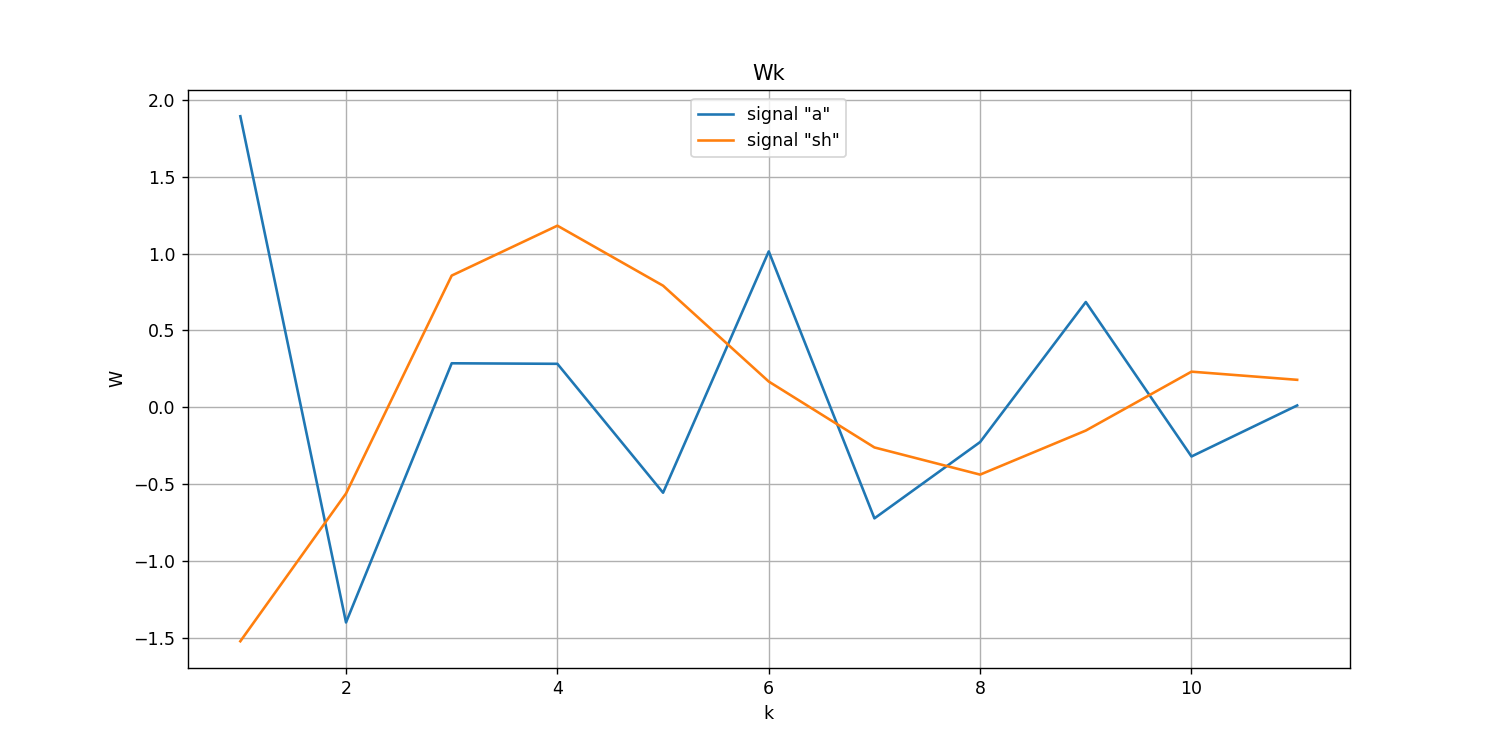

<ipython-input-50-ed8b1b8bbeb9>:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')


<IPython.core.display.Javascript object>


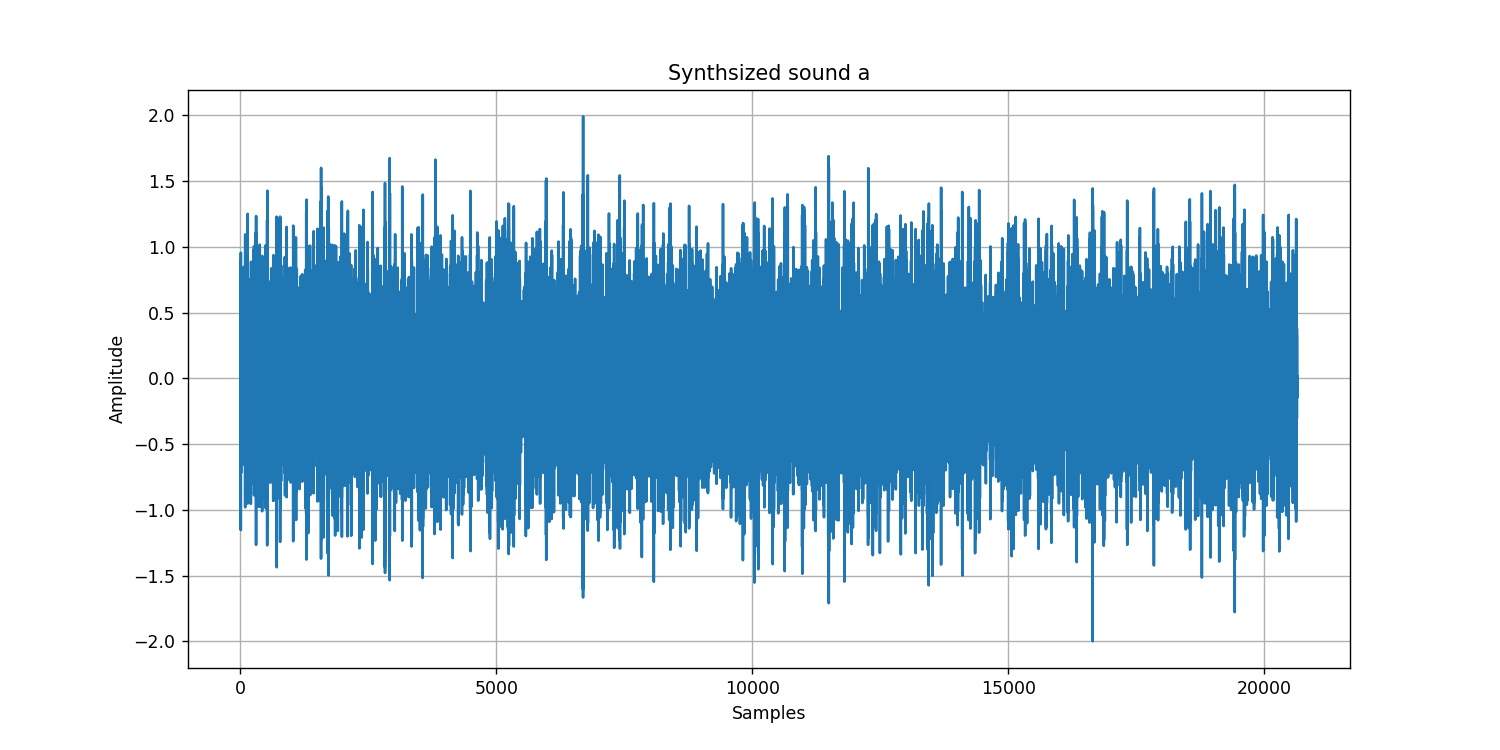

<IPython.core.display.Javascript object>


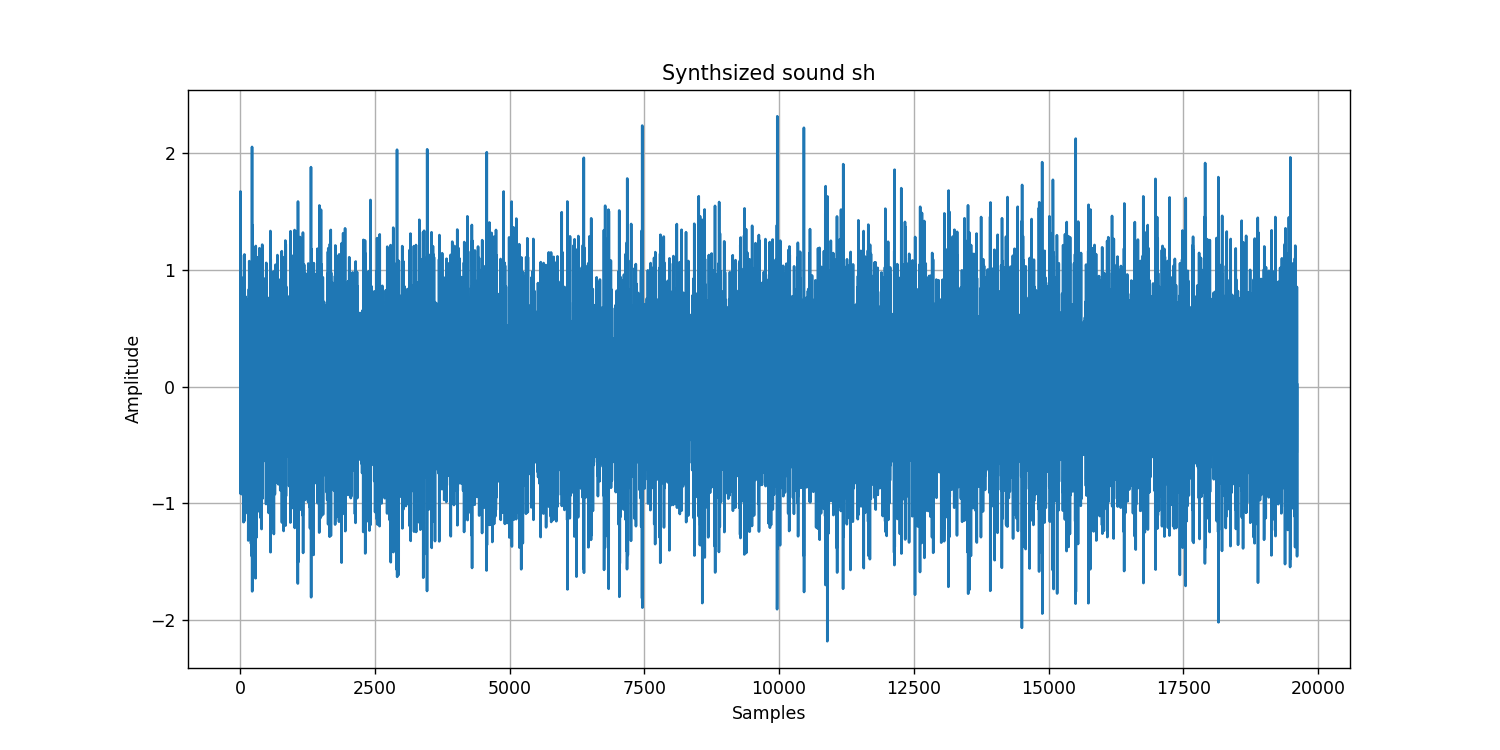

In [50]:
N = len(norm_a)
i = Mopt+1
r = autocorreltion(norm_a)
r = r[r.argmax():r.argmax()+i]
a_coefs_a, p_list = LevinsonDurbin(r)
wk_a = a_sub_k_to_w_sub_k(a_coefs_a)
noise_a = np.random.normal(0, np.sqrt(p_list[-1]), N)

N = len(norm_sh)
i = Mopt+1
r = autocorreltion(norm_sh)
r = r[r.argmax():r.argmax()+i]
a_coefs_sh, p_list = LevinsonDurbin(r)
wk_sh = a_sub_k_to_w_sub_k(a_coefs_sh)
noise_sh = np.random.normal(0,np.sqrt(p_list[-1]), N)

synth_a = filterW(noise_a, wk_a)
synth_sh = filterW(noise_sh, wk_sh)

plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('W')
plt.xlabel('k')
plt.title('Wk')
plt.grid('on')
plt.plot(np.arange(1,Mopt), wk_a, label='signal "a"')
plt.plot(np.arange(1,Mopt), wk_sh, label='signal "sh"')
plt.legend(loc='upper center')
plt.show()

plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.title('Synthsized sound a')
plt.grid('on')
plt.plot(synth_a)
plt.show()

plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.title('Synthsized sound sh')
plt.grid('on')
plt.plot(synth_sh)
plt.show()

In [52]:
IPython.display.Audio(noise_a,rate=desired_fs)

In [53]:
IPython.display.Audio(synth_sh,rate=desired_fs)

In [54]:
IPython.display.Audio(synth_a,rate=desired_fs)

### 6. Para el sonido /a/ y con Mo, realizar la recursión de Levinson-Durbin y representar los coeficientes κm en función de m.

In [55]:
i = Mopt+1
r = autocorreltion(norm_a)
r = r[r.argmax():r.argmax()+i]
_, p_list = LevinsonDurbin(r)
ks = list()

for m in range(1, len(p_list)):
    k_aux = np.sqrt(1-(p_list[m]/p_list[m-1]))
    ks.append(k_aux)


plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('Km')
plt.xlabel('m')
plt.title('Reflection coefficients (Km)')
plt.grid('on')
plt.plot(np.arange(1,len(p_list)), ks)
plt.show()

<IPython.core.display.Javascript object>